### Разобраться с моделькой перевода как она устроена (c механизмом внимания), запустить для перевода с русского на английский (при желании можно взять другие пары языков) внимание классическое с RNN-ками в энкодере и декодере

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

### Подготовка данных

In [2]:
# Download the file
path_to_file = "./data/translation/rus.txt"

In [3]:
def preprocess_sentence(w):
    w = w.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [4]:

preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [5]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENG, RUS]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [6]:
en, ru = create_dataset(path_to_file, None)
print(en[-1])
print(ru[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с уч том миллионов живущих на земле людей , ни один подходящи

In [7]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [8]:
def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [9]:
len(en), len(ru)

(431097, 431097)

In [10]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [11]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [12]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [13]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
13 ----> мы
21 ----> с
56 ----> томом
257 ----> рано
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> tom
152 ----> and
4 ----> i
22 ----> are
248 ----> early
3 ----> .
2 ----> <end>


In [14]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64

steps_per_epoch = len(input_tensor_train)//BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [17]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [19]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [20]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [21]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7260)


In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [23]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [24]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            
            loss += loss_function(targ[:, t], predictions)
            
            # using teacher forcing
            
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [25]:
EPOCHS = 50

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
      # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6727
Epoch 1 Batch 100 Loss 2.1352
Epoch 1 Batch 200 Loss 1.9186
Epoch 1 Batch 300 Loss 1.7454
Epoch 1 Batch 400 Loss 1.6087
Epoch 1 Batch 500 Loss 1.4623
Epoch 1 Batch 600 Loss 1.4013
Epoch 1 Batch 700 Loss 1.3587
Epoch 1 Batch 800 Loss 1.1047
Epoch 1 Batch 900 Loss 1.2480
Epoch 1 Batch 1000 Loss 1.1465
Epoch 1 Batch 1100 Loss 1.0617
Epoch 1 Batch 1200 Loss 0.9869
Epoch 1 Loss 1.4761
Time taken for 1 epoch 1130.671314716339 sec

Epoch 2 Batch 0 Loss 0.9636
Epoch 2 Batch 100 Loss 0.8917
Epoch 2 Batch 200 Loss 0.8279
Epoch 2 Batch 300 Loss 0.7802
Epoch 2 Batch 400 Loss 0.8271
Epoch 2 Batch 500 Loss 0.6959
Epoch 2 Batch 600 Loss 0.7424
Epoch 2 Batch 700 Loss 0.6432
Epoch 2 Batch 800 Loss 0.6595
Epoch 2 Batch 900 Loss 0.5973
Epoch 2 Batch 1000 Loss 0.5553
Epoch 2 Batch 1100 Loss 0.5968
Epoch 2 Batch 1200 Loss 0.5307
Epoch 2 Loss 0.7117
Time taken for 1 epoch 1106.9743678569794 sec

Epoch 3 Batch 0 Loss 0.4329
Epoch 3 Batch 100 Loss 0.3823
Epoch 3 Batch 200 Loss 0.34

Epoch 18 Batch 1000 Loss 0.0620
Epoch 18 Batch 1100 Loss 0.0688
Epoch 18 Batch 1200 Loss 0.0486
Epoch 18 Loss 0.0568
Time taken for 1 epoch 1099.8025221824646 sec

Epoch 19 Batch 0 Loss 0.0597
Epoch 19 Batch 100 Loss 0.0491
Epoch 19 Batch 200 Loss 0.0823
Epoch 19 Batch 300 Loss 0.0402
Epoch 19 Batch 400 Loss 0.0248
Epoch 19 Batch 500 Loss 0.0471
Epoch 19 Batch 600 Loss 0.0377
Epoch 19 Batch 700 Loss 0.0638
Epoch 19 Batch 800 Loss 0.0371
Epoch 19 Batch 900 Loss 0.0793
Epoch 19 Batch 1000 Loss 0.0610
Epoch 19 Batch 1100 Loss 0.0891
Epoch 19 Batch 1200 Loss 0.0810
Epoch 19 Loss 0.0558
Time taken for 1 epoch 1090.2785241603851 sec

Epoch 20 Batch 0 Loss 0.0313
Epoch 20 Batch 100 Loss 0.0501
Epoch 20 Batch 200 Loss 0.0312
Epoch 20 Batch 300 Loss 0.0323
Epoch 20 Batch 400 Loss 0.0418
Epoch 20 Batch 500 Loss 0.0576
Epoch 20 Batch 600 Loss 0.0608
Epoch 20 Batch 700 Loss 0.0469
Epoch 20 Batch 800 Loss 0.0607
Epoch 20 Batch 900 Loss 0.0755
Epoch 20 Batch 1000 Loss 0.0590
Epoch 20 Batch 1100 Loss

Epoch 36 Batch 100 Loss 0.0422
Epoch 36 Batch 200 Loss 0.0532
Epoch 36 Batch 300 Loss 0.0232
Epoch 36 Batch 400 Loss 0.0232
Epoch 36 Batch 500 Loss 0.0493
Epoch 36 Batch 600 Loss 0.0417
Epoch 36 Batch 700 Loss 0.0252
Epoch 36 Batch 800 Loss 0.0491
Epoch 36 Batch 900 Loss 0.0320
Epoch 36 Batch 1000 Loss 0.0538
Epoch 36 Batch 1100 Loss 0.0272
Epoch 36 Batch 1200 Loss 0.0343
Epoch 36 Loss 0.0429
Time taken for 1 epoch 1099.4229640960693 sec

Epoch 37 Batch 0 Loss 0.0412
Epoch 37 Batch 100 Loss 0.0361
Epoch 37 Batch 200 Loss 0.0360
Epoch 37 Batch 300 Loss 0.0194
Epoch 37 Batch 400 Loss 0.0536
Epoch 37 Batch 500 Loss 0.0340
Epoch 37 Batch 600 Loss 0.0292
Epoch 37 Batch 700 Loss 0.0414
Epoch 37 Batch 800 Loss 0.0336
Epoch 37 Batch 900 Loss 0.0360
Epoch 37 Batch 1000 Loss 0.0375
Epoch 37 Batch 1100 Loss 0.0559
Epoch 37 Batch 1200 Loss 0.0584
Epoch 37 Loss 0.0422
Time taken for 1 epoch 1094.224983215332 sec

Epoch 38 Batch 0 Loss 0.0258
Epoch 38 Batch 100 Loss 0.0265
Epoch 38 Batch 200 Loss 0.

In [26]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [27]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [29]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [30]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> всем привет . <end>
Predicted translation: hi , everybody . <end> 


/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


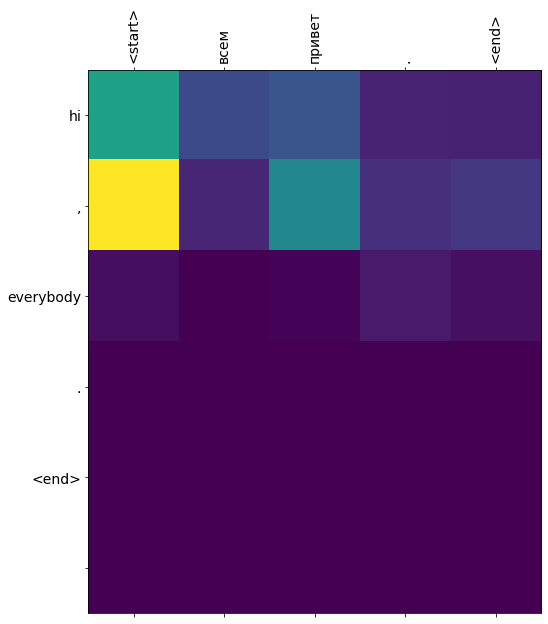

In [55]:
translate('Всем привет.')

Input: <start> я сижу и делаю работу <end>
Predicted translation: i'm doing my work . <end> 


/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


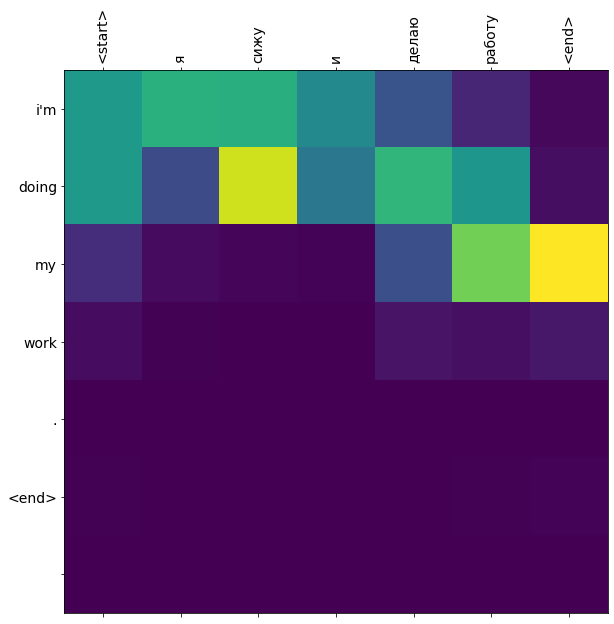

In [56]:
translate('Я сижу и делаю работу')

Input: <start> мы запустим у себя такую же систему <end>
Predicted translation: we really end . <end> 


/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


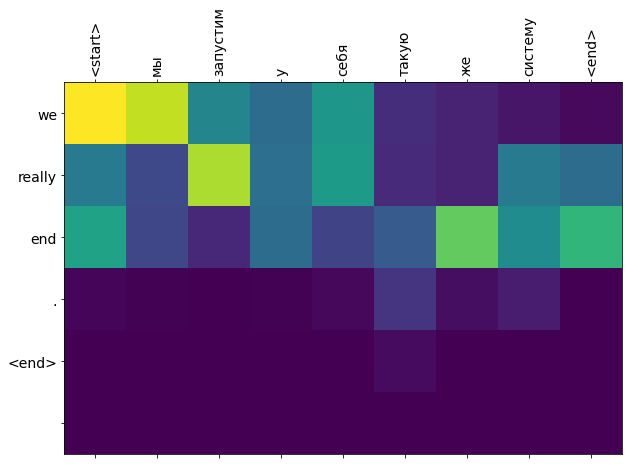

In [57]:
translate('Мы запустим у себя такую же систему')

Input: <start> я хочу тебе позвонить <end>
Predicted translation: i want to call you ? <end> 


/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


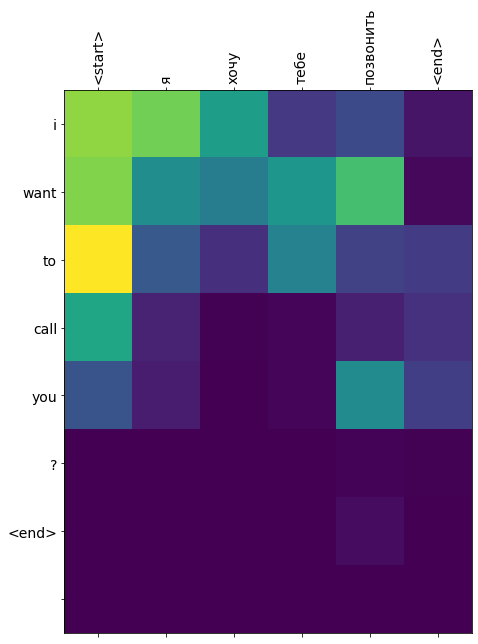

In [58]:
translate('я хочу тебе позвонить')

Input: <start> вопросы по теме занятия можно задать <end>
Predicted translation: let no arm come out . <end> 


/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


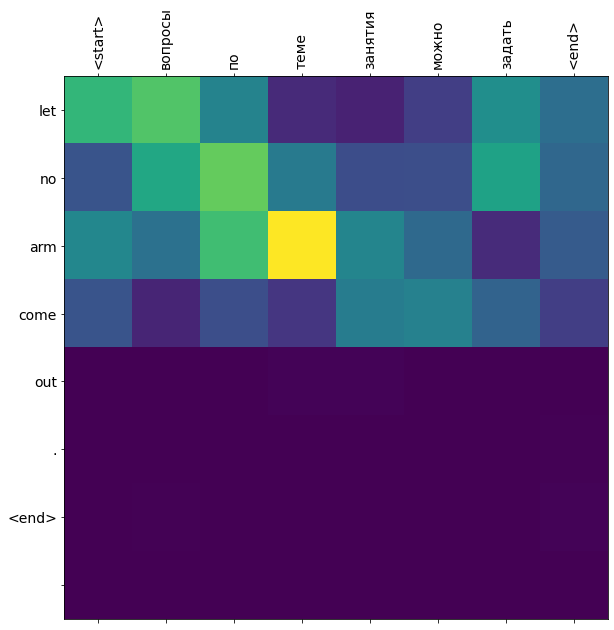

In [59]:
translate('Вопросы по теме занятия можно задать')

Input: <start> она отказала , мужчина уш л ни с чем , но через некоторое время вернулся , чтобы отомстить . <end>
Predicted translation: i had no such to get was left . <end> 


/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


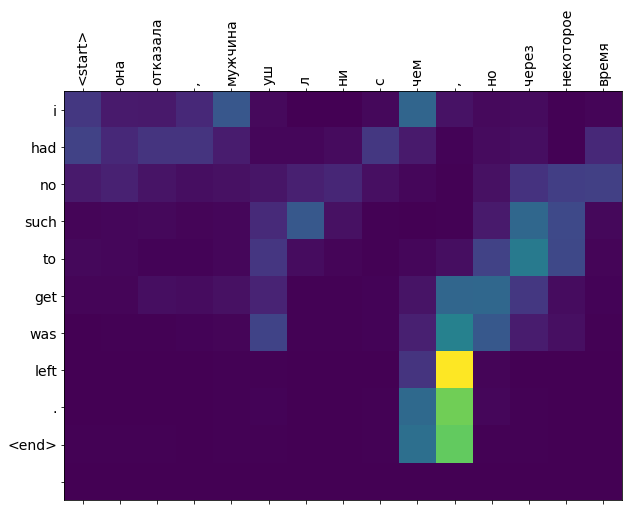

In [47]:
translate('Она отказала, мужчина ушёл ни с чем, но через некоторое время вернулся, чтобы отомстить.')

Input: <start> результат для большого числа слов плохой <end>
Predicted translation: no one is for sure . <end> 


/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


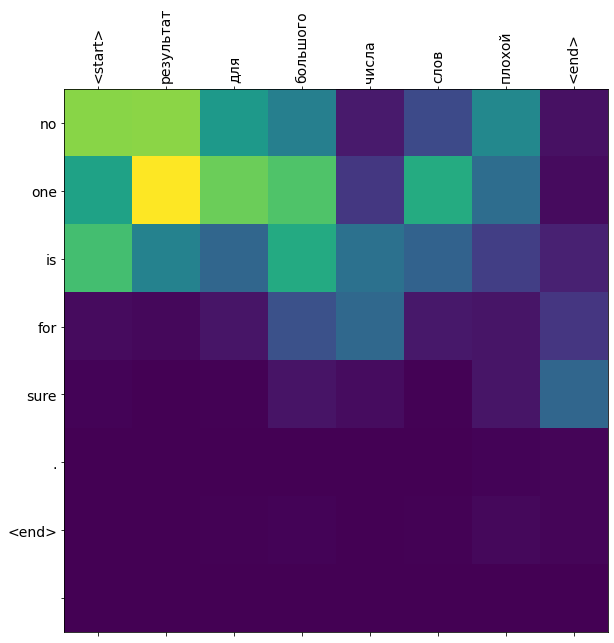

In [61]:
translate('Результат для большого числа слов плохой')